# Imports

In [1]:
import torch
import numpy as np
import torch.nn as nn
from zuko.utils import odeint
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
from tqdm.auto import trange



# Model and Loss

In [2]:
class OTFlowMatching(nn.Module):
    def __init__(self, sigma_min = 1e-5):
        super().__init__()
        self.sigma_min = torch.tensor(sigma_min)

    def psi_t(self, X0, X1, t):
        return (1-(1-self.sigma_min.to(X1.device))*t)*X0 + t*X1 ## this is the psi function in the paper X(t) = psi_t(X(0), X(1))
    def forward(self, VXt, X0, X1,t):
        return nn.functional.mse_loss(VXt, (X1 - (1-self.sigma_min.to(X1.device))*X0)) # ||Vt(X(t)) - dpsi_t(X(0), X(1))/dt||

class TVMLP(nn.Module):
    def __init__(self, in_dim, hiddens, out_dim, n_classes=0):
        super().__init__()
        layers = []
        self.input_dim = in_dim
        self.n_classes = n_classes
        conditional_dim = nn.functional.one_hot(torch.zeros([1]).long(), self.n_classes).shape[-1] if n_classes != 0 else 0 ## adding one-hot encoding dim for conditional generation
        in_dim = in_dim + 1 + conditional_dim
         # adding a time dimension to the input
        for hidden in hiddens:
            layers.append(nn.Linear(in_dim, hidden))
            layers.append(nn.LeakyReLU())
            in_dim = hidden
        layers.append(nn.Linear(in_dim, out_dim))
        self.layers = nn.Sequential(*layers)
    def forward(self, Xt,t, y=None):

        Xt_t = torch.cat([Xt.to(t.dtype),t], dim=1)
        if self.n_classes >0:
          y = nn.functional.one_hot(y.long(),self.n_classes).to(t.dtype) ## one-hot encoding labels for conditional generation

          Xt_t = torch.cat([Xt_t, y], dim=1)
        return self.layers(Xt_t)

    def odeint_function(self,t,X):
        p = next(self.parameters())
        device = p.device
        dtype = p.dtype
        t = t*torch.ones([X.shape[0],1], dtype=dtype, device=device) # preparing t for batch inference
        if self.n_classes>0:
          return self(X, t, self.y_gen)
        else:
          return self(X, t)

    def generate(self, num_samples=10000, y=None):
        p = next(self.parameters())
        device = p.device
        dtype = p.dtype
        X0 = torch.randn([num_samples, self.input_dim], dtype=dtype, device=device) # initializing X0
        if self.n_classes >0:
          self.y_gen = y*torch.ones([X0.shape[0]], dtype=dtype, device=device) # preparing label for batch generation
        X1 = odeint(self.odeint_function, X0, 0., 1., self.parameters()) # Solving for dphi_t(X)/dt = v_t(X)
        return X1




# Dataset

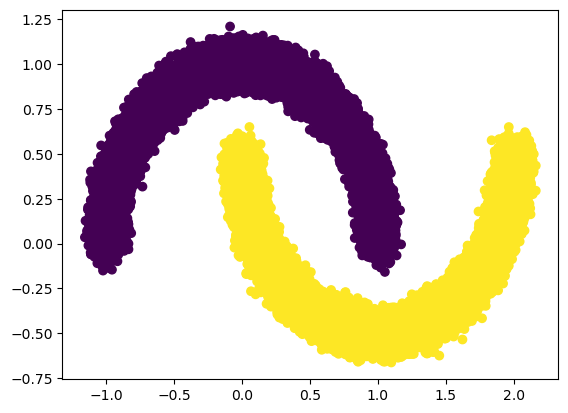

In [3]:

X, y = make_moons(n_samples=100000, noise=0.05) # dataset generation

plt.scatter(X[:,0],X[:,1], c=y)


# Training Without Class Condition

  0%|          | 0/1000 [00:00<?, ?it/s]

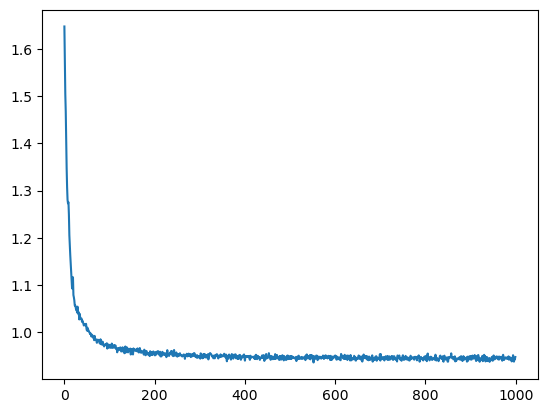

In [4]:
model = TVMLP(in_dim=X.shape[-1], out_dim=X.shape[-1], hiddens=[128, 512, 1024, 512, 128]).cuda()
FMM=OTFlowMatching()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
losses = []
epochs = 1000
for epoch in trange(epochs):
    optimizer.zero_grad()
    X1 = torch.from_numpy(X).cuda().to(torch.float32)
    t = torch.rand(X.shape[0]).reshape([-1,1]).cuda().to(torch.float32) # initializing a random t
    X0 = torch.randn_like(X1).cuda() #initializing X0
    Xt = FMM.psi_t(X0, X1, t) # Computing Xt
    VXt = model(Xt, t) # forward pass
    loss = FMM(VXt, X0, X1,t)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    if epoch % 10 == 0:
      scheduler.step()
plt.plot(losses)

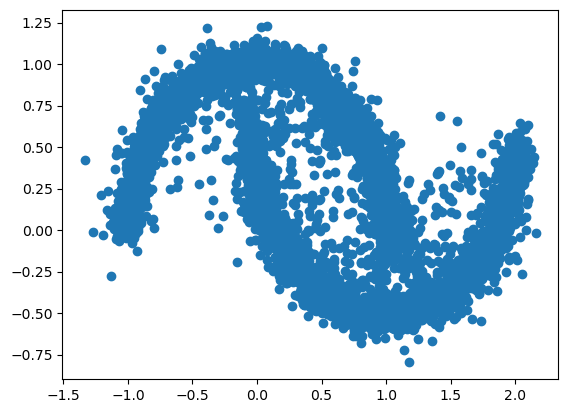

In [5]:
X1 = model.generate(10000)
X1 = X1.detach().cpu().numpy()
plt.scatter(X1[:,0],X1[:,1])

# Training With Class Condition

  0%|          | 0/1000 [00:00<?, ?it/s]

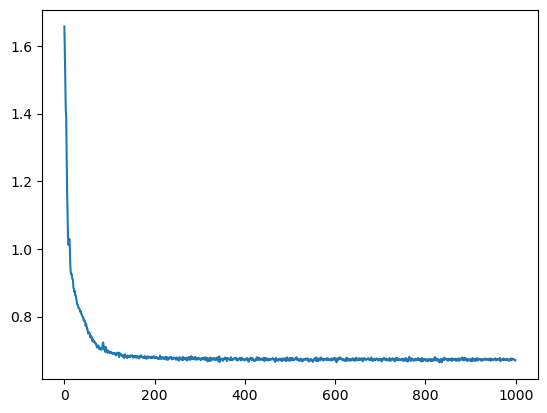

In [6]:
model = TVMLP(in_dim=X.shape[-1], out_dim=X.shape[-1], hiddens=[128, 512, 1024, 512, 128], n_classes=len(np.unique(y))).cuda()
FMM=OTFlowMatching()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
losses = []
epochs = 1000
for epoch in trange(epochs):
    optimizer.zero_grad()
    X1 = torch.from_numpy(X).cuda().to(torch.float32)
    y_tensor = torch.from_numpy(y).cuda().to(torch.float32)
    t = torch.rand(X.shape[0]).reshape([-1,1]).cuda().to(torch.float32) # initializing a random t
    X0 = torch.randn_like(X1).cuda() #initializing X0
    Xt = FMM.psi_t(X0, X1, t) # Computing Xt
    VXt = model(Xt, t, y_tensor) # forward pass
    loss = FMM(VXt, X0, X1,t)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    if epoch % 10 == 0:
      scheduler.step()
plt.plot(losses)

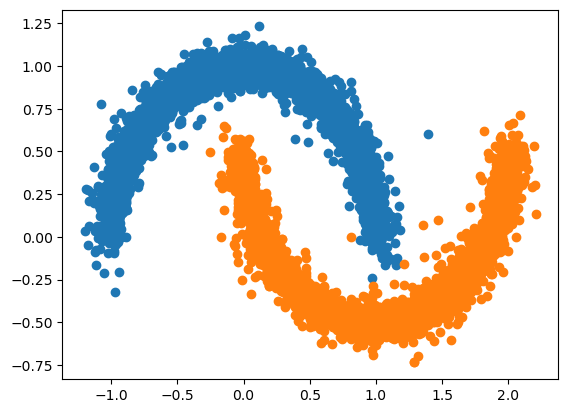

In [7]:
for c in np.unique(y):
  X1 = model.generate(5000,c)
  X1 = X1.detach().cpu().numpy()
  plt.scatter(X1[:,0],X1[:,1],label=c)